# Imports

In [6]:
import mne
import xml.etree.ElementTree as ET
import pywt
import scipy.stats as stats
import scipy.fftpack as fft
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.utils.helpers.edf_data_import import (
    compute_signal_features,
    extract_all_eeg_signals,
)

In [7]:
# Define paths to the MAT files
edf_mat_path = "../../data/EDF_RawData.mat"  # rows correspond to time samples and columns correspond to channels
xml_mat_path = "../../data/XML_RawData.mat"

In [8]:
all_eeg_signals = extract_all_eeg_signals(edf_mat_path, channel=0)
print("Number of EDF files processed:", len(all_eeg_signals))
for idx, signal in enumerate(all_eeg_signals):
    print(f"EDF file {idx + 1} signal shape: {signal.shape}")

# Display features for each extracted signal
all_features = [compute_signal_features(signal) for signal in all_eeg_signals]
features_df = pd.DataFrame(all_features)
print("EEG Signal Features for All EDF Files:")
display(features_df)

Number of EDF files processed: 10
EDF file 1 signal shape: (4065000,)
EDF file 2 signal shape: (4065000,)
EDF file 3 signal shape: (4046250,)
EDF file 4 signal shape: (3933750,)
EDF file 5 signal shape: (3281250,)
EDF file 6 signal shape: (4065000,)
EDF file 7 signal shape: (4065000,)
EDF file 8 signal shape: (3446250,)
EDF file 9 signal shape: (3596250,)
EDF file 10 signal shape: (4072500,)
EEG Signal Features for All EDF Files:


,mean,variance,rms,peak_to_peak,zero_crossings,hjorth_activity,hjorth_mobility,hjorth_complexity
0,0.635573,58.852684,7.697833,98.045319,0,58.852684,0.041293,34.286007
1,0.774338,74.707297,8.677955,99.217212,0,74.707297,0.036339,38.912563
2,0.745668,69.886851,8.393025,99.217212,0,69.886851,0.057425,24.611791
3,0.761866,72.415477,8.543765,99.217212,0,72.415477,0.032868,43.069614
4,0.765756,73.105161,8.584378,99.217212,0,73.105161,0.035437,39.965012
5,0.760500,71.834660,8.509584,99.217212,0,71.834660,0.020344,69.735927
6,0.761192,72.030855,8.521166,98.045319,0,72.030855,0.021696,65.316734
7,0.758827,72.827450,8.567571,99.998474,0,72.827450,0.036741,39.043975
8,0.768386,73.572287,8.611777,99.217212,0,73.572287,0.036789,38.477290
9,0.671379,61.432532,7.866593,98.045319,0,61.432532,0.035815,40.029995


In [53]:
# Load EDF file
edf_path = "Data/R4.edf"  # Update path if needed
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Get metadata
n_channels = len(raw.ch_names)
sfreq = int(raw.info['sfreq'])  # Sampling frequency

raw.info

Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3281249  =      0.000 ... 26249.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_13020\568775105.py:3: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: SaO2, H.R., EEG(sec), ECG, EMG, EOG(L), EOG(R), EEG, THOR RES, ...
 chs: 14 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 125.0 Hz
 subject_info: <subject_info | his_id: >
>

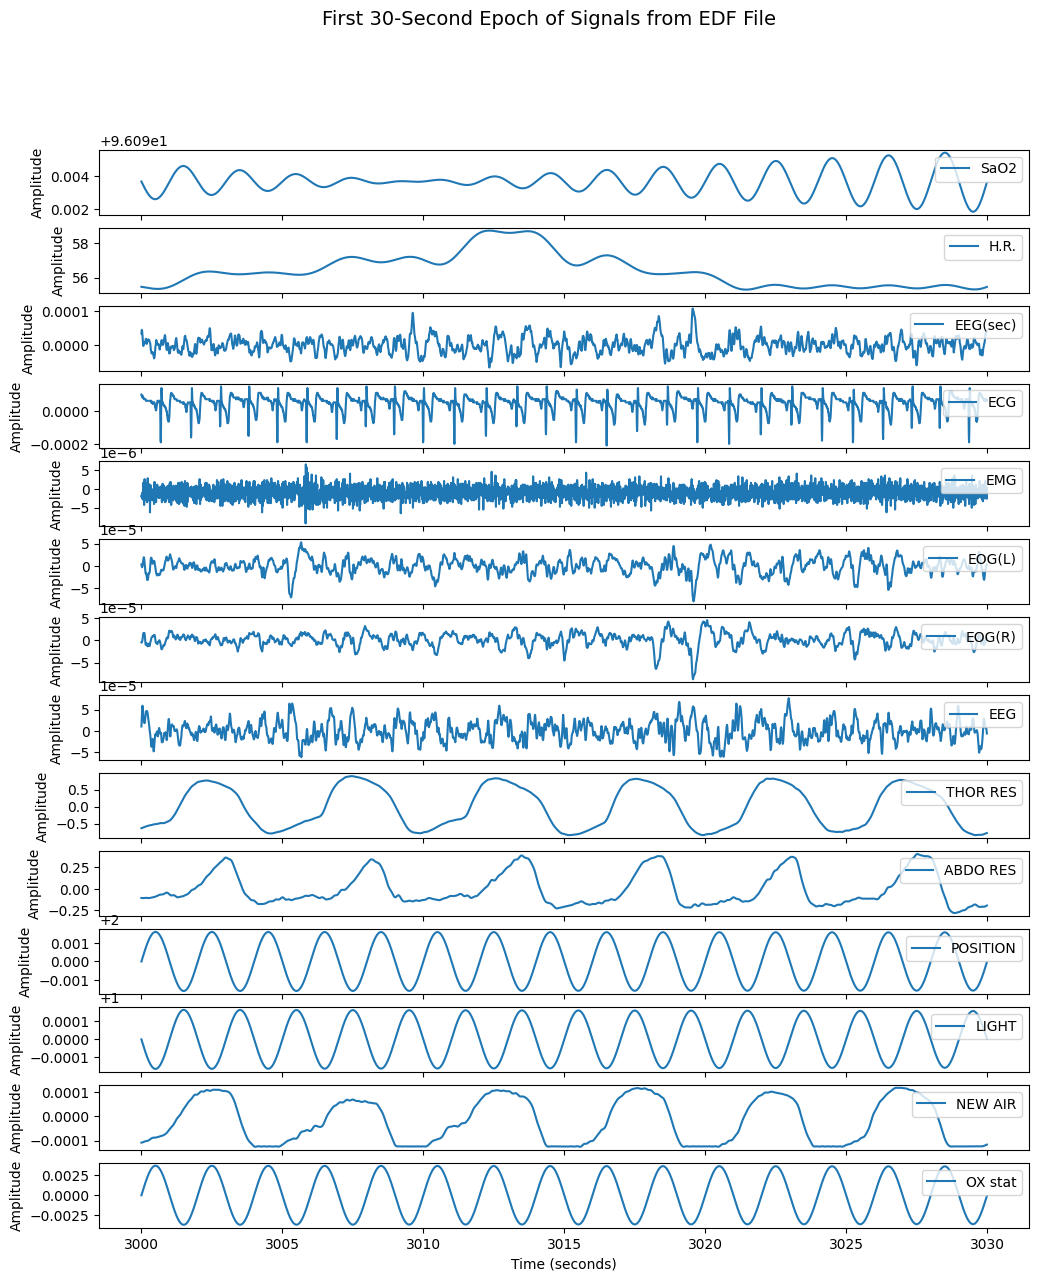

In [54]:
# Define a 30-second epoch
epoch_duration = 30  # seconds
epoch_samples = sfreq * epoch_duration

# Extract first epoch
start_sample = epoch_samples * 100
end_sample = start_sample + epoch_samples
data, times = raw[:, start_sample:end_sample]

# Create subplots for each channel
fig, axes = plt.subplots(n_channels, 1, figsize=(12, n_channels), sharex=True)

# Plot each channel
for i, ax in enumerate(axes):
    ax.plot(times, data[i], label=raw.ch_names[i])
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")

# Common labels and title
axes[-1].set_xlabel("Time (seconds)")
plt.suptitle("First 30-Second Epoch of Signals from EDF File", fontsize=14)
plt.show()

In [55]:
def read_xml(xml_filename):
    """ Parses the XML file and extracts events, sleep stages, epoch length, and annotations. """
    try:
        tree = ET.parse(xml_filename)
        root = tree.getroot()
    except Exception as e:
        raise RuntimeError(f"Failed to read XML file {xml_filename}: {e}")

    # Extract epoch length
    epoch_length = int(root.find("EpochLength").text)

    # Define sleep stage mapping
    stage_mapping = {
        "SDO:NonRapidEyeMovementSleep-N1": 4,
        "SDO:NonRapidEyeMovementSleep-N2": 3,
        "SDO:NonRapidEyeMovementSleep-N3": 2,
        "SDO:NonRapidEyeMovementSleep-N4": 1,
        "SDO:RapidEyeMovementSleep": 0,  # REM sleep
        "SDO:WakeState": 5               # Wake state
    }

    # Initialize storage
    events = []
    stages = []
    
    # Parse events
    for scored_event in root.find("ScoredEvents"):
        event_concept = scored_event.find("EventConcept").text
        start = float(scored_event.find("Start").text)
        duration = float(scored_event.find("Duration").text)

        # Check if event is a sleep stage
        if event_concept in stage_mapping:
            stages.extend([stage_mapping[event_concept]] * int(duration))
        else:
            # Extract additional attributes if available
            spo2_nadir = scored_event.find("SpO2Nadir")
            spo2_baseline = scored_event.find("SpO2Baseline")
            desaturation = scored_event.find("Desaturation")

            event_data = {
                "EventConcept": event_concept,
                "Start": start,
                "Duration": duration,
                "SpO2Nadir": float(spo2_nadir.text) if spo2_nadir is not None else None,
                "SpO2Baseline": float(spo2_baseline.text) if spo2_baseline is not None else None,
                "Desaturation": float(desaturation.text) if desaturation is not None else None
            }
            events.append(event_data)

    return events, stages, epoch_length, bool(events)

# Example usage:
xml_path = "Data/R4.xml"  # Update with correct path
events, stages, epoch_length, has_annotations = read_xml(xml_path)
print("Epoch Length:", epoch_length)
print("Number of Events:", len(events))
print("Number of Sleep Stages:", len(stages))

Epoch Length: 30
Number of Events: 268
Number of Sleep Stages: 26220


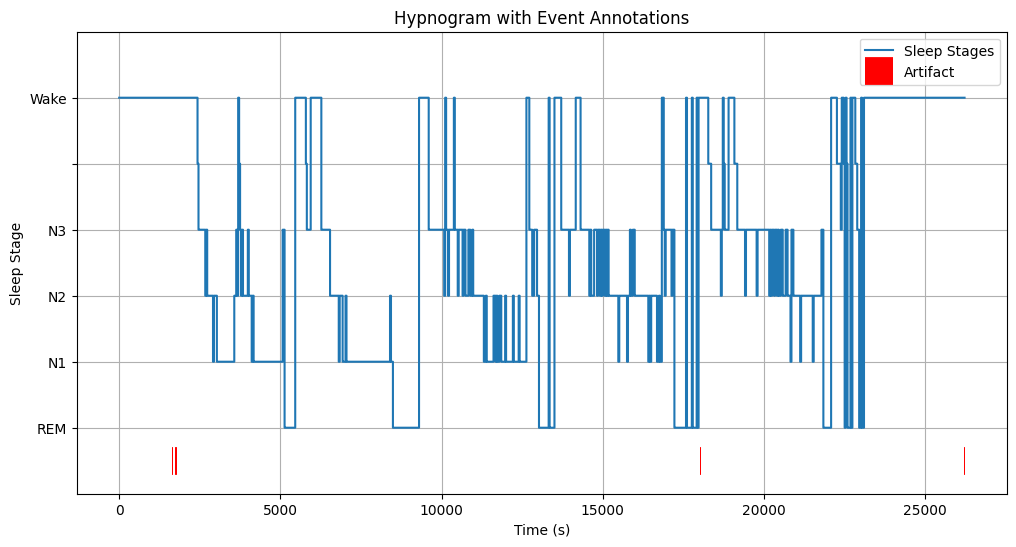

In [ ]:
# Prepare the plot
time = np.arange(len(stages))

# Plot hypnogram
plt.figure(figsize=(12, 6))
plt.plot(time, stages, drawstyle="steps-post", label="Sleep Stages")

# Overlay annotations
hypopnea_plotted = False
for event in events:
    start_idx = int(event["Start"])
    end_idx = start_idx + int(event["Duration"])
    if event["EventConcept"] == "SignalArtifactEvent":
        plt.hlines(y=-0.5, xmin=start_idx, xmax=end_idx, colors='r', linestyles='dashed', linewidth=20, label='Artifact' if not hypopnea_plotted else "")
        hypopnea_plotted = True

# Formatting
plt.ylim([-1, 6])
plt.yticks([0, 1, 2, 3, 4, 5], ["REM", "", "N3", "N2", "N1", "Wake"])
plt.xlabel("Time (s)")
plt.ylabel("Sleep Stage")
plt.title("Hypnogram with Event Annotations")
plt.legend()
plt.grid()
plt.show()


# ECG data treatment

In [57]:
# Preprocessing
# Load EDF file
edf_path = "Data/R4.edf"  # Update path if needed
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Get metadata
n_channels = len(raw.ch_names)
sfreq = int(raw.info['sfreq'])  # Sampling frequency

# Define a 30-second epoch
epoch_duration = 30  # seconds
epoch_samples = sfreq * epoch_duration

# Extract the ECG signal
data, times = raw[:]
ECG_signal = data[3]


Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3281249  =      0.000 ... 26249.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_13020\2805363985.py:4: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB



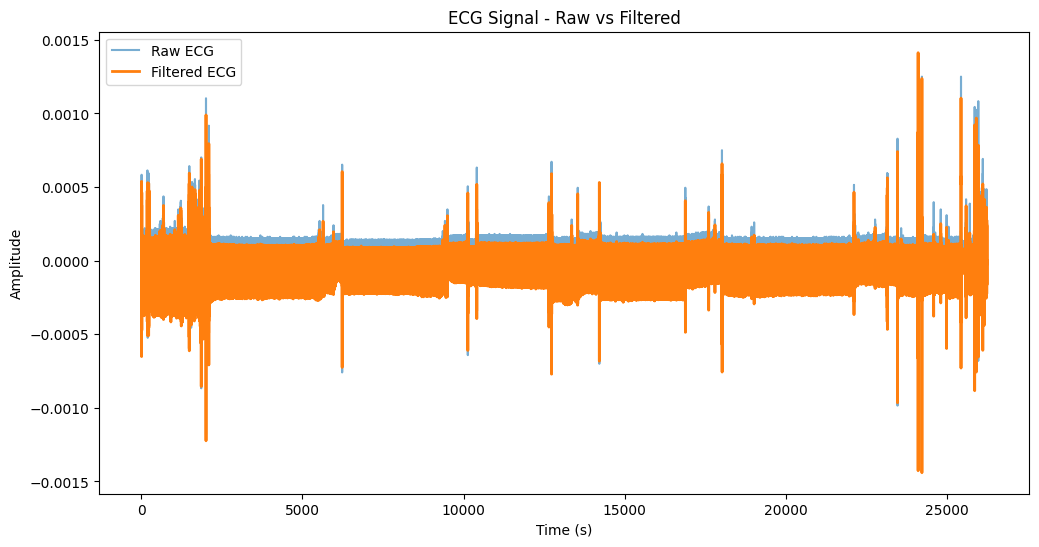

In [58]:
# Filtering
# Define filter parameters
low_cutoff = 0.5  # Remove baseline drift
high_cutoff = 40  # Remove high-frequency noise
notch_freq = 60  # Remove powerline interference

# Apply bandpass filter (0.5 - 40 Hz)
ECG_filtered = mne.filter.filter_data(ECG_signal, sfreq, low_cutoff, high_cutoff, method='iir')

# Apply notch filter (e.g., 60 Hz)
ECG_filtered = mne.filter.notch_filter(ECG_filtered, sfreq, freqs=notch_freq, method='iir')

# Plot original vs filtered signal
plt.figure(figsize=(12, 6))
plt.plot(times, ECG_signal, label="Raw ECG", alpha=0.6)
plt.plot(times, ECG_filtered, label="Filtered ECG", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal - Raw vs Filtered")
plt.legend()
plt.show()

In [60]:
# Epochs that contain artifacts
time_artifact = []
for event in events:
    start_idx = int(event["Start"])
    end_idx = start_idx + int(event["Duration"])
    if event["EventConcept"] == "SignalArtifactEvent":
        time_artifact.append(start_idx)
        time_artifact.append(end_idx)
        
epochs_artifacts = []
for t in time_artifact:
    epochs_artifacts.append(t//30)

# Epochs at the beginning and at the end to be removed
epoch_start = 100
epoch_end = num_epochs-100


In [62]:
# Define parameters
wavelet = 'db4'  # Daubechies wavelet (common for ECG)
level = 4  # Decomposition level
epoch_samples = int(sfreq * 30)  # 30-second epoch size

# Function to extract wavelet features
def extract_wavelet_features(signal, wavelet, level):
    """Extracts mean, std, energy, and entropy from wavelet coefficients."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    
    for c in coeffs:
        features.append(np.mean(c))  # Mean
        features.append(np.std(c))   # Standard deviation
        features.append(np.sum(np.square(c)))  # Energy
        features.append(stats.entropy(np.abs(c) + 1e-6))  # Entropy (avoid log(0))
    
    return np.array(features)

# Function to extract statistical features
def extract_statistical_features(signal):
    """Computes mean, median, variance, skewness, and kurtosis."""
    return np.array([
        np.mean(signal),
        np.median(signal),
        np.var(signal),
        np.std(signal),
        stats.skew(signal),
        stats.kurtosis(signal)
    ])

# Function to extract frequency-domain features
def extract_frequency_features(signal, sfreq):
    """Computes power spectral density features using FFT."""
    freqs = fft.fftfreq(len(signal), d=1/sfreq)
    power_spectrum = np.abs(fft.fft(signal)) ** 2
    
    # Define frequency bands
    lf_band = (0.04, 0.15)  # Low Frequency (LF)
    hf_band = (0.15, 0.4)   # High Frequency (HF)

    # Compute power in each band
    lf_power = np.sum(power_spectrum[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
    hf_power = np.sum(power_spectrum[(freqs >= hf_band[0]) & (freqs < hf_band[1])])
    lf_hf_ratio = lf_power / (hf_power + 1e-6)  # Avoid division by zero
    
    return np.array([lf_power, hf_power, lf_hf_ratio])

# Function to extract time-domain features
def extract_time_features(signal):
    """Computes RMS and MAD."""
    rms = np.sqrt(np.mean(signal ** 2))
    mad = np.mean(np.abs(signal - np.mean(signal)))
    return np.array([rms, mad])

# Segment ECG signal into 30-second epochs and extract features
num_epochs = len(ECG_filtered) // epoch_samples
all_features = []

for i in range(epoch_start, epoch_end):
    if i in epochs_artifacts:
        continue
    start = i * epoch_samples
    end = start + epoch_samples
    epoch_signal = ECG_filtered[start:end]

    wavelet_feats = extract_wavelet_features(epoch_signal, wavelet, level)
    statistical_feats = extract_statistical_features(epoch_signal)
    frequency_feats = extract_frequency_features(epoch_signal, sfreq)
    time_feats = extract_time_features(epoch_signal)

    # Concatenate all features
    features = np.concatenate([wavelet_feats, statistical_feats, frequency_feats, time_feats])
    all_features.append(features)

# Convert to NumPy array
all_features = np.array(all_features)

# Save features
np.save("ECG_features.npy", all_features)  # Save as .npy file
df = pd.DataFrame(all_features)
df.to_csv("ECG_features.csv", index=False)  # Save as CSV for easier inspection

print("Extracted features shape:", all_features.shape)
print("Saved features to ECG_features.npy and ECG_features.csv")

Extracted features shape: (669, 31)
Saved features to ECG_features.npy and ECG_features.csv


In [85]:
# Load extracted features
features = np.load("ECG_features.npy")  # Shape: (num_epochs, num_features)

# Generate labels (skip artifacts)
labels = []
filtered_indices = []  # To track valid (non-artifact) indices

for i in range(epoch_start, epoch_end):
    if i in epochs_artifacts:
        continue
    label = stages[30*i+15]
    if label>1:
        label = label-1
    labels.append(label)  # Assign corresponding stage label
    filtered_indices.append(i)

labels = np.array(labels)  # Convert list to numpy array

# Ensure number of labels matches features
assert features.shape[0] == len(labels), "Mismatch between features and labels!"

In [86]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Assuming labels are integers
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [87]:
class ECGClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Get input size & number of classes
input_size = X_train.shape[1]  # Number of features
num_classes = len(np.unique(labels))  # Number of unique labels

# Initialize model
model = ECGClassifier(input_size, num_classes)


In [89]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch 1/20, Loss: 1.2393
Epoch 2/20, Loss: 1.2226
Epoch 3/20, Loss: 1.2209
Epoch 4/20, Loss: 1.2286
Epoch 5/20, Loss: 1.2379
Epoch 6/20, Loss: 1.2222
Epoch 7/20, Loss: 1.2232
Epoch 8/20, Loss: 1.2184
Epoch 9/20, Loss: 1.2210
Epoch 10/20, Loss: 1.2155
Epoch 11/20, Loss: 1.2203
Epoch 12/20, Loss: 1.2074
Epoch 13/20, Loss: 1.2083
Epoch 14/20, Loss: 1.2028
Epoch 15/20, Loss: 1.2064
Epoch 16/20, Loss: 1.2030
Epoch 17/20, Loss: 1.2030
Epoch 18/20, Loss: 1.2033
Epoch 19/20, Loss: 1.1955
Epoch 20/20, Loss: 1.2084
Training complete!


In [90]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

Test Accuracy: 0.4776
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.16      0.26        19
           1       0.56      0.75      0.64        61
           2       0.27      0.26      0.27        34
           3       0.00      0.00      0.00         3
           4       0.40      0.35      0.38        17

    accuracy                           0.48       134
   macro avg       0.40      0.31      0.31       134
weighted avg       0.48      0.48      0.45       134



c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


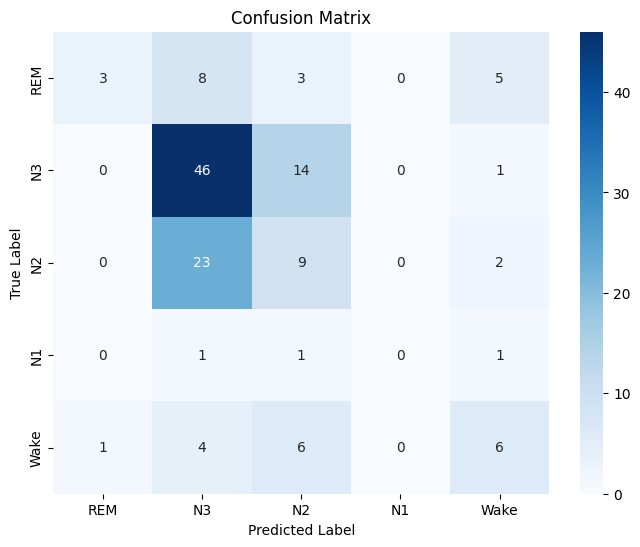

In [92]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define label names
label_names = ["REM", "N3", "N2", "N1", "Wake"]

# Get predictions
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())  # Convert tensor to numpy
        y_true.extend(y_batch.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()